## Importing the libraries

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
# library for train test split
from sklearn.model_selection import train_test_split

In [3]:
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [5]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

## Dataset

### Loading the dataset

In [6]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
duplicatedRow = messages[messages.duplicated()]
duplicatedRow.head()

,label,message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls


In [9]:
messages.groupby('label').describe().T

label                              ham                                               spam
message count                     4825                                                747
        unique                    4516                                                653
        top     Sorry, I'll call later  Please call our customer service representativ...
        freq                        30                                                  4

There are 4,825 ham compared to 747 spam messages. This indicates the imbalanced data which we will fix later. The most popular ham message is “Sorry, I’ll call later”, whereas the most popular spam message is “Please call our customer service…” which occurred 30 and 4 times, respectively.

In [10]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

In [11]:
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

### Word Cloud for ham messages

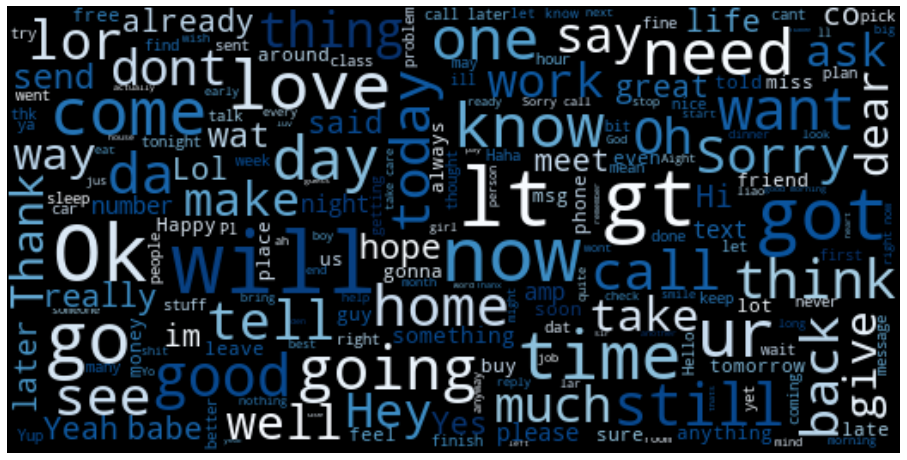

In [12]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

As observed from WordCloud, the most used words in ham messages are "Ok", "will", "love","now" etc.

### Word Cloud for spam messages

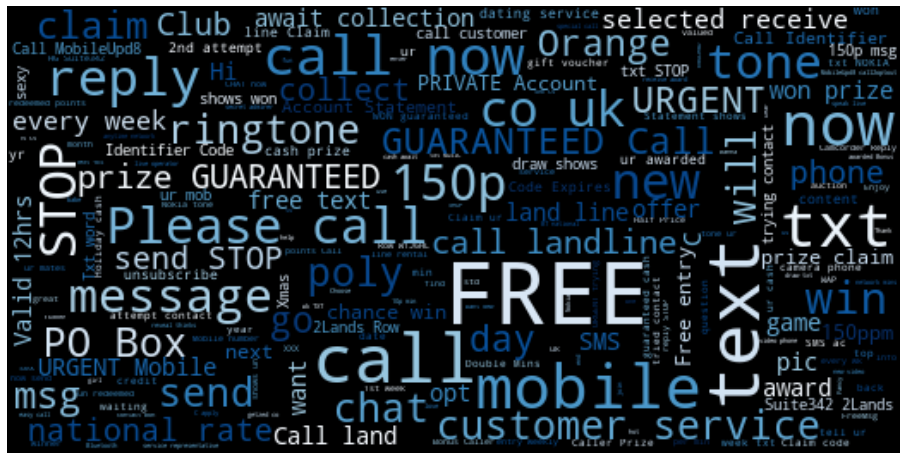

In [13]:
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()


As obserevd from the WordCloud of the spam messages, "Free", "text", "call", "mobile" etc. are the most commonly used words.

### Plotting the distribution of Spam and Ham messages

15.481865284974095

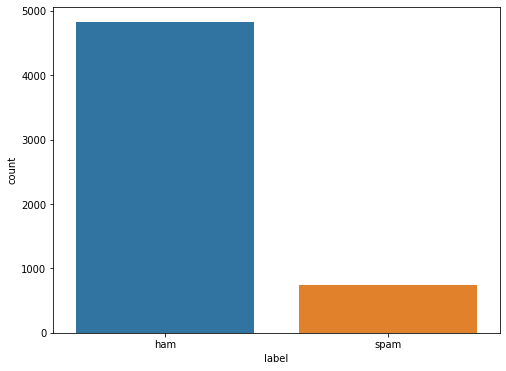

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

There are most frequent ham messages (85%) than spam (15%).

For handling datasets that are class imbalanced many techniques are available. These include:
1. Oversampling the minority class
2. Undersampling the majority class
3. change of evaluation metrics
4. ensembling different resample datasets

For the domain of this problem only undersampling of the majority class is done.



### Down-sampling the majority class

In [15]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


#### Plotting the distribution of spam and ham messages after resampling

Text(0.5, 0, 'Message types')

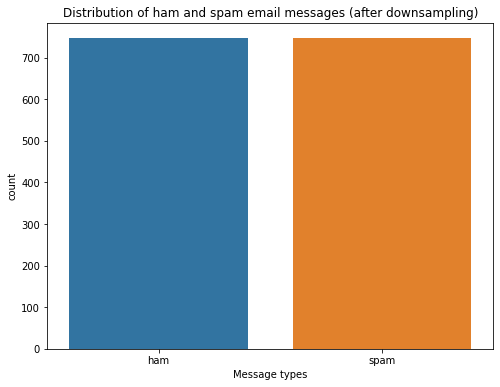

In [16]:
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

#### Finding the average lenghts of messages

In [17]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


The average length of a spam message is more than that of a ham message. This can act as a good differentiating feature.

## Pre-processing the data
The following steps would be undertaken for pre-processing the data:
1. Converting the text data label into numeric and performing a test-train split.

2. The next step is tokenization.

3. The above steps are followed by sequencing and padding.


In [18]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

### Tokenization

In [19]:
# Hyper-parameters for tokenization
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [20]:
# Using the Tokenizer() to tokenize the words
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [21]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [22]:
# Checking the number of unique tokens
tot_tokens = len(word_index)
print('No. of unique token ==> ', tot_tokens)

No. of unique token ==>  4169


### Sequencing and Padding

The next step after tokenization is to convert each sentence into a sequence of numbers followed by padding so that each each sequence will have the same length.

In [23]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [24]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [25]:
# Checking the length of sequences before and after padding
print("Before padding ==> ", len(training_sequences[0]))
print("After padding ==> ",len(training_padded[1]))

Before padding ==>  27
After padding ==>  50


## Classification

### Dense Spam Detection Model

In [26]:
# Hyper Parameters
vocab_size = 500
embeding_dim = 16
drop_value = 0.2
n_dense = 24

In [27]:
# Model Architecture for dense network
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compiling the dense model
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])

In [30]:
# Training the dense model
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

history = model.fit(training_padded, train_labels,
                    epochs = num_epochs, validation_data = (testing_padded, test_labels),
                    callbacks = [early_stop], verbose = 2)

Epoch 1/30
38/38 - 1s - loss: 0.6885 - accuracy: 0.6485 - val_loss: 0.6795 - val_accuracy: 0.8127
Epoch 2/30
38/38 - 0s - loss: 0.6630 - accuracy: 0.8402 - val_loss: 0.6426 - val_accuracy: 0.8161
Epoch 3/30
38/38 - 0s - loss: 0.6092 - accuracy: 0.8586 - val_loss: 0.5760 - val_accuracy: 0.8328
Epoch 4/30
38/38 - 0s - loss: 0.5285 - accuracy: 0.8787 - val_loss: 0.4929 - val_accuracy: 0.8696
Epoch 5/30
38/38 - 0s - loss: 0.4431 - accuracy: 0.8929 - val_loss: 0.4150 - val_accuracy: 0.8696
Epoch 6/30
38/38 - 0s - loss: 0.3652 - accuracy: 0.8971 - val_loss: 0.3541 - val_accuracy: 0.8796
Epoch 7/30
38/38 - 0s - loss: 0.3058 - accuracy: 0.9121 - val_loss: 0.3072 - val_accuracy: 0.8896
Epoch 8/30
38/38 - 0s - loss: 0.2600 - accuracy: 0.9213 - val_loss: 0.2674 - val_accuracy: 0.8963
Epoch 9/30
38/38 - 0s - loss: 0.2205 - accuracy: 0.9389 - val_loss: 0.2369 - val_accuracy: 0.8997
Epoch 10/30
38/38 - 0s - loss: 0.1947 - accuracy: 0.9406 - val_loss: 0.2049 - val_accuracy: 0.9197
Epoch 11/30
38/38 -

In [31]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.9398


[0.12556526064872742, 0.9397993087768555]

In [32]:
# Read the metrics as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column for plotting
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

def plot_graphs1(var1, var2, string):
  """
  plots the graph of var1, var2 vs number of epochs 
  """
  metrics[[var1, var2]].plot()
  plt.title('Training and Validation ' + string)
  plt.xlabel ('Number of epochs')
  plt.ylabel(string)
  plt.legend([var1, var2])


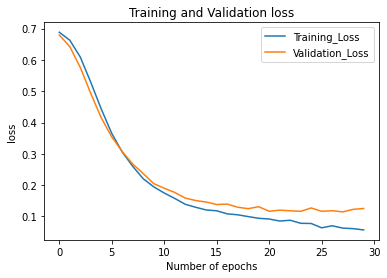

In [33]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

As observed from the above graph, both the training and validation loss decrease as the number of epochs increase until they flatten around 25 epochs.

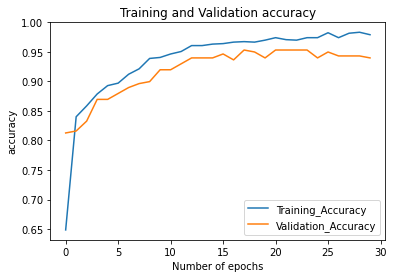

In [34]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

As observed from the graph, both the training accuracy and the validation accuracy increase with an increase in number of epochs. The training accuracy reaches around 95% and the validation accuracy around 93%.

### LSTM Model

In [35]:
# LSTM hyperparameters
n_lstm = 20
drop_lstm = 0.2

In [36]:
# LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [37]:
# Compiling the LSTM Model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [38]:
# Training and evaluating the LSTM Model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, 
                     epochs=num_epochs, validation_data=(testing_padded, test_labels),
                     callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 6s - loss: 0.6533 - accuracy: 0.6290 - val_loss: 0.5256 - val_accuracy: 0.7324
Epoch 2/30
38/38 - 2s - loss: 0.3592 - accuracy: 0.8721 - val_loss: 0.3075 - val_accuracy: 0.9112
Epoch 3/30
38/38 - 2s - loss: 0.2614 - accuracy: 0.9218 - val_loss: 0.2934 - val_accuracy: 0.9111
Epoch 4/30
38/38 - 2s - loss: 0.2214 - accuracy: 0.9365 - val_loss: 0.2375 - val_accuracy: 0.9269
Epoch 5/30
38/38 - 2s - loss: 0.1939 - accuracy: 0.9417 - val_loss: 0.2655 - val_accuracy: 0.9201
Epoch 6/30
38/38 - 2s - loss: 0.1791 - accuracy: 0.9448 - val_loss: 0.2615 - val_accuracy: 0.9183


In [39]:
# Create a dataframe of metrics
metrics = pd.DataFrame(history.history)
# Rename columns for plotting
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

def plot_graphs1(var1, var2, string):
    """
    plots the graph of var1, var2 vs number of epochs 
    """
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

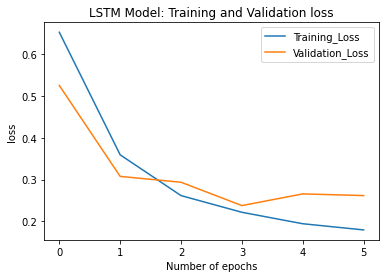

In [40]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

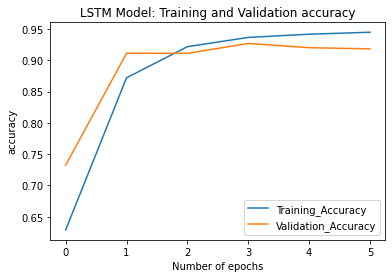

In [41]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Bi-directional LSTM Model

In [42]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [43]:
# Compiling the Bi-LSTM Model
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [44]:
# Training and evaluating the Bi-LSTM model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 6s - loss: 0.6722 - accuracy: 0.6204 - val_loss: 0.6063 - val_accuracy: 0.7087
Epoch 2/30
38/38 - 1s - loss: 0.4039 - accuracy: 0.8755 - val_loss: 0.2824 - val_accuracy: 0.9179
Epoch 3/30
38/38 - 1s - loss: 0.2282 - accuracy: 0.9422 - val_loss: 0.2014 - val_accuracy: 0.9445
Epoch 4/30
38/38 - 1s - loss: 0.1834 - accuracy: 0.9533 - val_loss: 0.2457 - val_accuracy: 0.9299
Epoch 5/30
38/38 - 1s - loss: 0.1594 - accuracy: 0.9597 - val_loss: 0.1723 - val_accuracy: 0.9542
Epoch 6/30
38/38 - 1s - loss: 0.1452 - accuracy: 0.9637 - val_loss: 0.1660 - val_accuracy: 0.9528
Epoch 7/30
38/38 - 1s - loss: 0.1189 - accuracy: 0.9711 - val_loss: 0.1764 - val_accuracy: 0.9522
Epoch 8/30
38/38 - 1s - loss: 0.1098 - accuracy: 0.9730 - val_loss: 0.1573 - val_accuracy: 0.9545
Epoch 9/30
38/38 - 1s - loss: 0.1072 - accuracy: 0.9746 - val_loss: 0.1744 - val_accuracy: 0.9526
Epoch 10/30
38/38 - 1s - loss: 0.0957 - accuracy: 0.9764 - val_loss: 0.1614 - val_accuracy: 0.9573


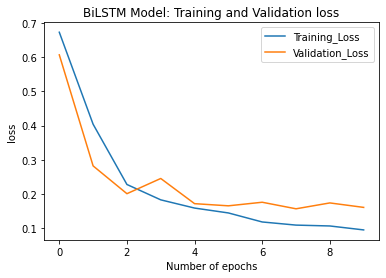

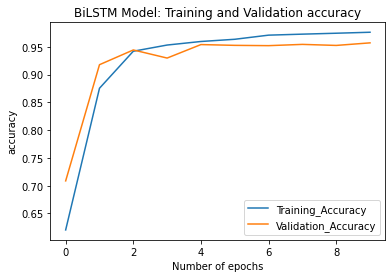

In [45]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    """
    plots the graph of var1, var2 vs number of epochs 
    """
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

# Plots
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Comparison of the three models

In [46]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 2ms/step - loss: 0.1256 - accuracy: 0.9398
Dense architecture loss and accuracy: [0.12556526064872742, 0.9397993087768555] 
10/10 [==============================] - 0s 9ms/step - loss: 0.2615 - accuracy: 0.9183
LSTM architecture loss and accuracy: [0.26145800948143005, 0.9182608723640442] 
10/10 [==============================] - 0s 7ms/step - loss: 0.1614 - accuracy: 0.9573
Bi-LSTM architecture loss and accuracy: [0.16140392422676086, 0.9572574496269226] 
